In [1]:
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import torch
import os
import sys
plt.style.use('../support/plot_style.txt')

2024-11-25 19:01:57.234865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
save_dir = './maps_at_different_weights/'

coord_dir = Path('../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878/')
coord_dir1 = Path('../../downloaded_data/conformations/ChromoGen/specific_regions/GM12878/')

mcool_fp = '../../outside_data/hic/GM12878_hg19.mcool'
dipc_fp = '../../downloaded_data/conformations/DipC/processed_data.h5'
region_length = 1_280_000

chroms_regions = [
    ('1',29020000),
    ('4',83760000),
    ('10',110860000),
    ('12',52640000)
]

n_bootstrap_resamples = 25

In [3]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
exp_hic = HiCDataset(mcool_fp)

In [5]:
config_ds = ConfigDataset(
    dipc_fp,
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

In [6]:
torch.random.manual_seed(10); # for reproducibility

In [7]:
def load_coords(chrom,start_idx,coord_dir=coord_dir,coord_dir1=coord_dir1):

    fn1 = f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'
    fn2 = f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'

    if (coord_dir / fn1).exists():
        cd = coord_dir
    else:
        cd = coord_dir1
    
    f1 = cd / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_1.0_rescaled_phi_0.0.pt'
    f2 = cd / f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_5.0_rescaled_phi_8.0.pt'

    return tuple(Conformations(f,drop_invalid_conformations=True) for f in [f1,f2])    

In [8]:
for chrom, start in chroms_regions:
    a,b = load_coords(chrom,start)

In [9]:
def bootstrapped_median(
    dists1,
    dists2,
    fraction_w1,
    n=n_bootstrap_resamples
):

    # No bootstrapping necessary in these cases
    if fraction_w1 == 0:
        return dists2.median
    if fraction_w1 == .5:
        return dists1.append(dists2).median
    if fraction_w1 == 1:
        return dists1.median

    n1 = len(dists1)
    n2 = len(dists2)
    N = n1 + n2
    
    median_dist_resamples = []
    for _ in range(n):

        # Decide how many samples to draw from each 
        # set of conformations
        nn1 = ( torch.rand(N) < fraction_w1 ).sum()
        nn2 = N - nn1
    
        # Draw samples to construct new dataset, find median dists, record result
        median_dist_resamples.append(
            dists1[torch.randint(n1,(nn1,))].append(
                dists2[torch.randint(n2,(nn2,))]
            ).median
        )

    return median_dist_resamples[0].append(median_dist_resamples[1:]).median
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 6 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'equal', 'nonmarkingreturn', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 32]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 6 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'equal', 'nonmarkingreturn', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 32]
INFO:fontTools.subset:Closing glyph list over 'glyf': 6 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'equal', 'nonmarkingreturn', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [

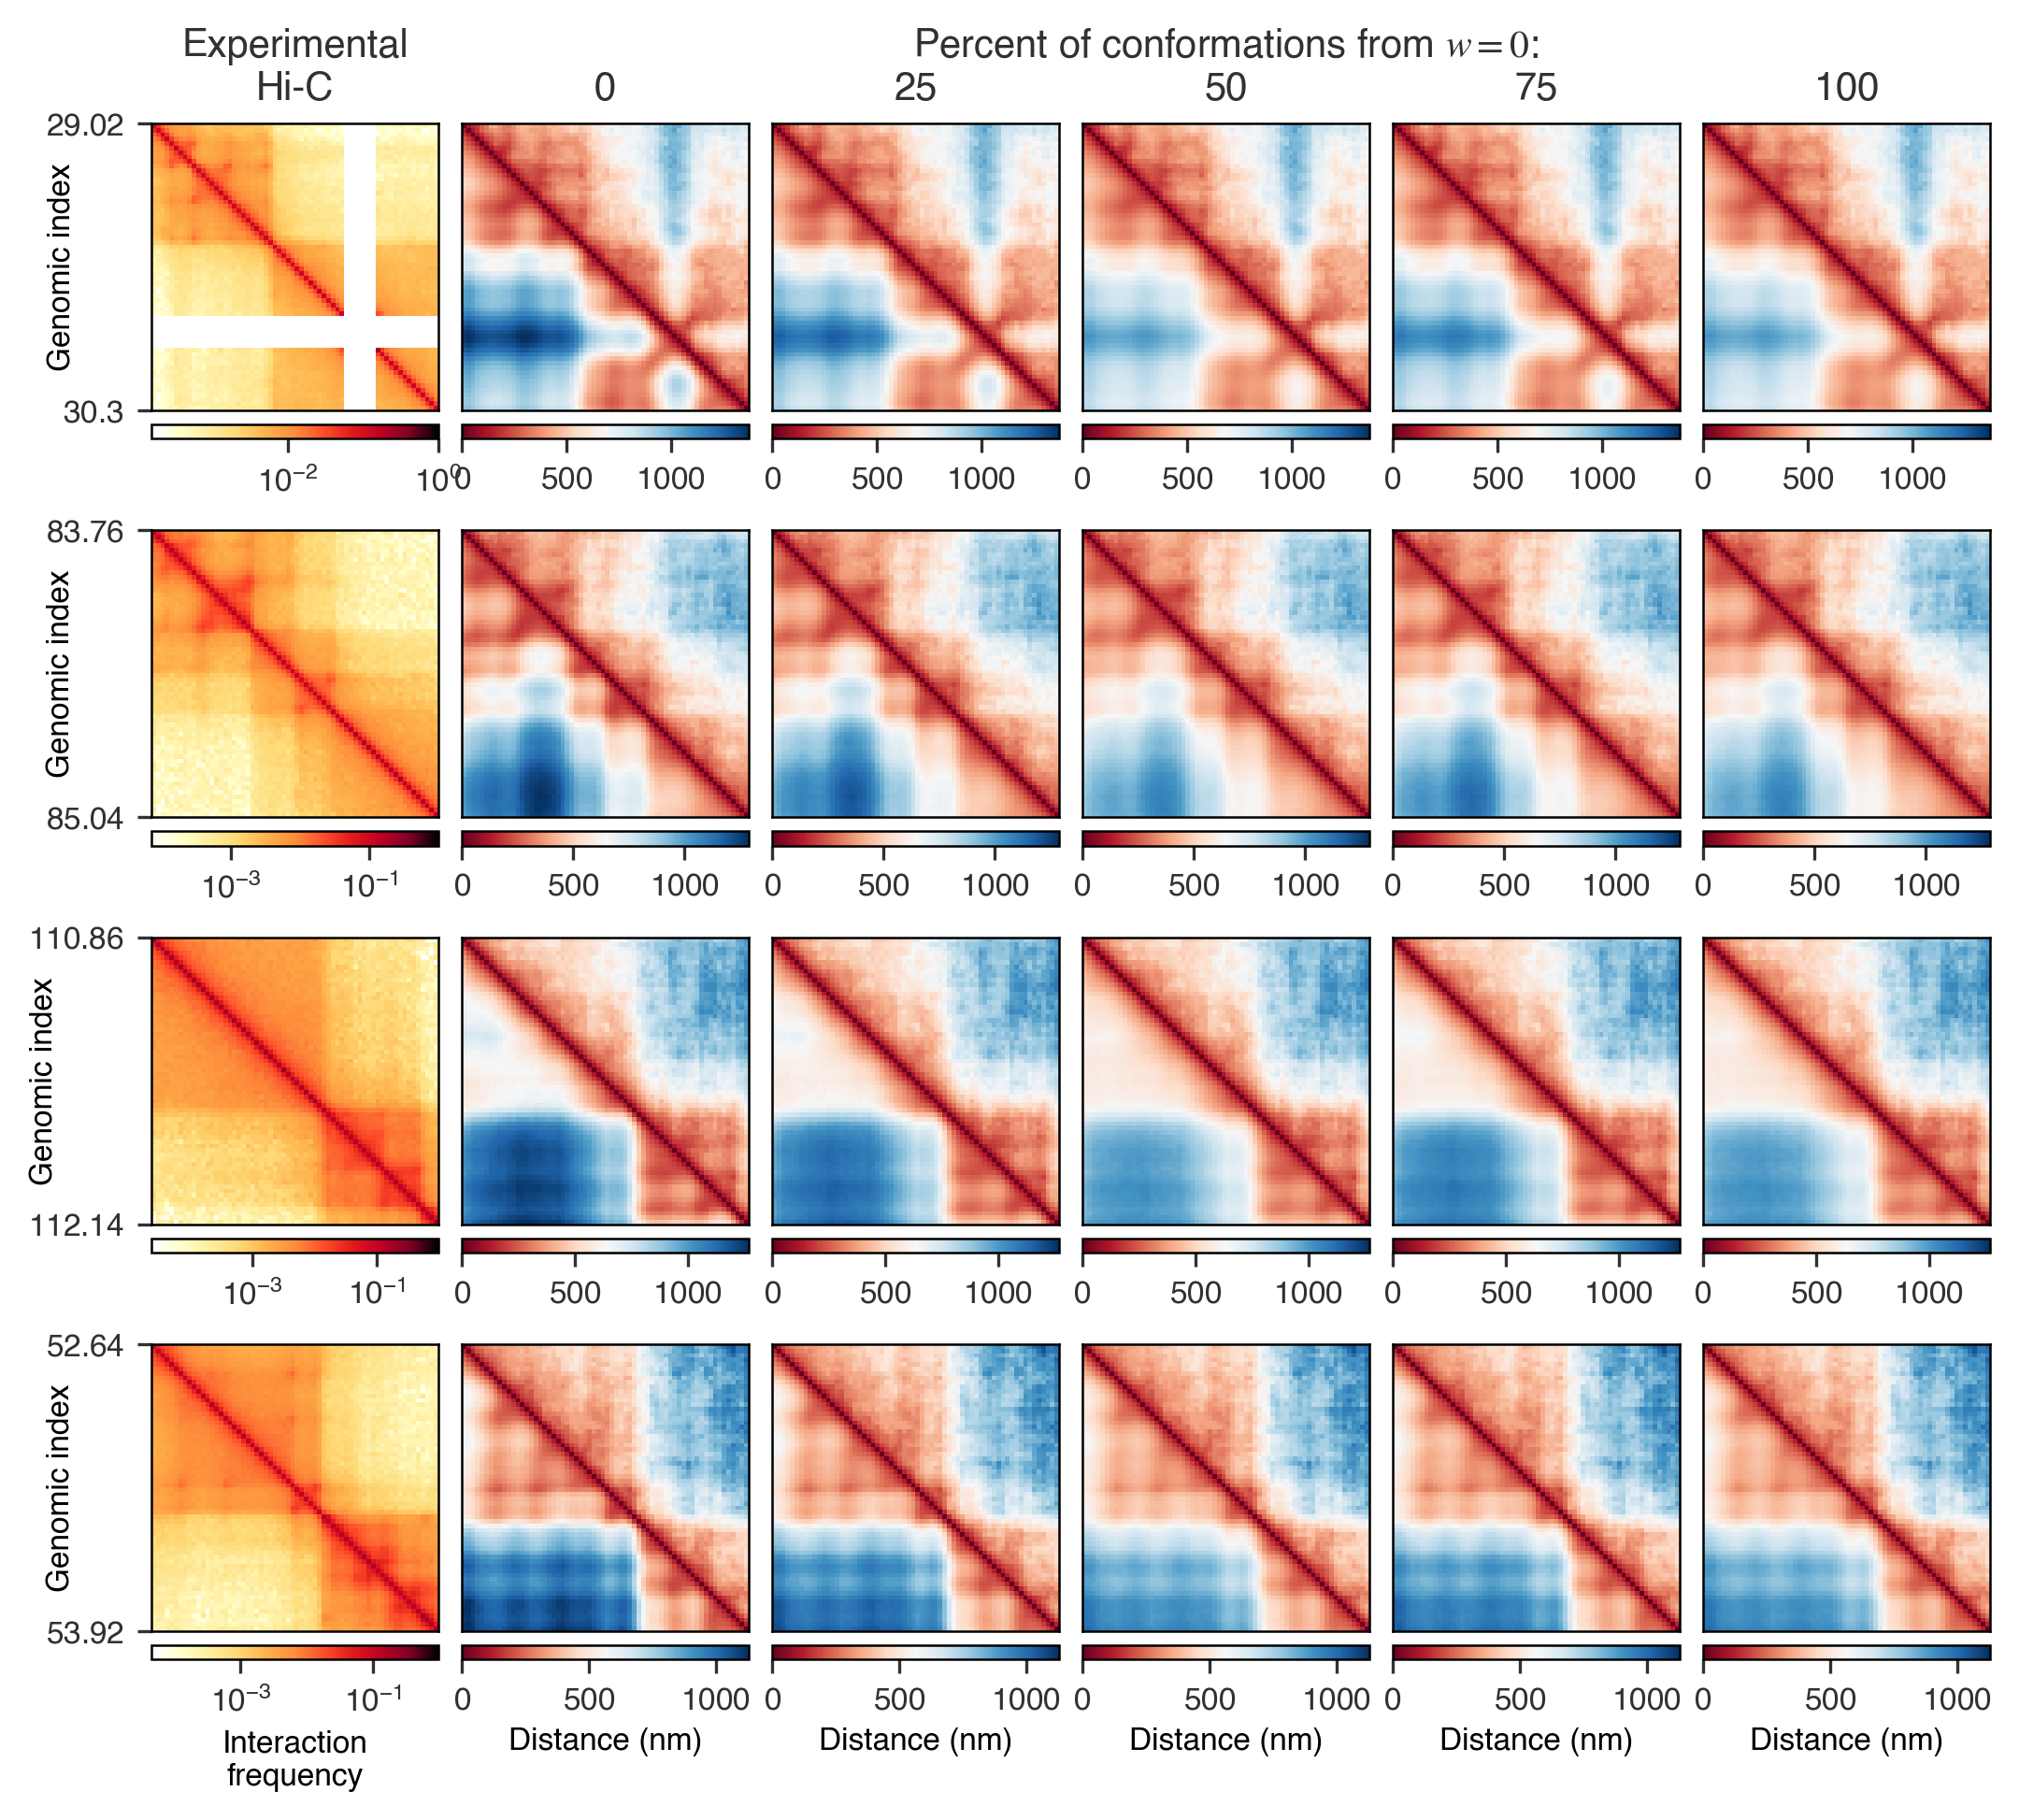

In [10]:
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(7.08,6.692*.9),layout='constrained')

w1_fractions = [0.,.25,.5,.75,1.]

for i,(chrom,start) in enumerate(chroms_regions):

    coords1,coords2 = load_coords(chrom,start)
    dists1 = coords1.distances
    dists2 = coords2.distances
    dists1._values*= 100 # convert to nm
    dists2._values*= 100 
    del coords1, coords2

    vmax = dists2.median.values.max()

    # Plot Hi-C
    ax = axes[i][0]
    *_,cbar=exp_hic.fetch(chrom,start,start + region_length).plot(fig=fig,ax=ax,cbar_orientation='horizontal')
    start1 = round(start/1e6,3)
    stop1 = round((start+region_length)/1e6,3)
    ax.set_yticks(ax.get_ylim(),labels=['$\\mathdefault{'f'{v}'+'}$' for v in [stop1,start1]])
    ax.set_ylabel('Genomic index',labelpad=-8)

    if i == 0:
        ax.set_title('Experimental\nHi-C')
    if i != 3:
        cbar.set_label('')
    else:
        cbar.set_label('Interaction\nfrequency')

    # Get Dip-C coordinates
    dipc_dists = Conformations(config_ds.fetch_specific_coords(chrom,start)[1]).distances.median.float()
    dipc_dists._values*= 100 
    
    for j,frac in enumerate(w1_fractions):

        ax = axes[i][j+1]
        
        *_,cbar = dipc_dists.plot_with(
            bootstrapped_median(dists1,dists2,frac),
            fig=fig,
            ax=ax,
            cbar_orientation='horizontal',
            vmax=vmax
        )

        if i == 0:
            if j == 2:
                ax.set_title('Percent of conformations from $w=0$:\n' + f'{round(100*frac)}')
            else:
                ax.set_title(f'{round(100*frac)}')
        if i == 3:
            cbar.set_label('Distance (nm)')
        else:
            cbar.set_label('')
        ax.set_ylabel('')
    
fig.savefig(save_dir + 'visualize_w1_fraction.pdf')